In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import csv
import io
import os



In [36]:
DATA_PATH = "../cleaned_output.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6.0,"Week day lunch,At a party,Late night snack",5.0,cloudy with a chance of meatballs,coca cola,Friends,A little (mild),Pizza
1,715742,4,2.0,"Week day lunch,At a party,Late night snack",5.0,all sort of american young boy movies,coca cola,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5.0,"Week day lunch,Week day dinner,Weekend lunch,W...",NaN,action movie,coca cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6.5,"Week day lunch,Week day dinner,Weekend lunch,W...",3.0,mamma mia,pop,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3.0,"Week day lunch,Week day dinner,Weekend lunch,W...",5.0,cloudy with a chance of meatballs,pop,"Siblings,Friends",A little (mild),Pizza


In [37]:
Q3 = 'Q3: In what setting would you expect this food to be served? Please check all that apply'
Q7 = 'Q7: When you think about this food item, who does it remind you of?'
Q8 = 'Q8: How much hot sauce would you add to this food item?'
Q5 = 'Q5: What movie do you think of when thinking of this food item?'
Q6 = 'Q6: What drink would you pair with this food item?'
Q2 = 'Q2: How many ingredients would you expect this food item to contain?'
# df = df.drop(columns=[Q5, Q6], errors='ignore')  # These columns can have a lot of different values resulting in a large number of columns after one-hot encoding

In [38]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns.remove('Label')
comma_separated_features = [Q3, Q8]

print(f"Total categorical columns: {len(categorical_columns)}")
print(f"Processing {len(comma_separated_features)} comma-separated features")

# More efficient approach for comma-separated features
for feature in comma_separated_features:
    if feature in df.columns:
        # Create a temporary series with lists of options
        options_series = df[feature].fillna('').str.split(',')
        
        # Get all unique options across all rows efficiently
        unique_options = set()
        for options_list in options_series:
            unique_options.update([opt.strip() for opt in options_list if opt.strip()])
            
        print(f"'{feature.split(':')[0]}' has {unique_options}\n")
        
        # Create binary columns in a vectorized way
        feature_prefix = feature.split(':')[0] + "_"
        for option in unique_options:
            # Use vectorized string operations instead of apply
            df[f"{feature_prefix}{option}"] = options_series.apply(
                lambda x: any(opt.strip() == option for opt in x)
            )
        
        # Drop original column
        df.drop(columns=[feature], inplace=True)

df.drop(columns=[Q7], inplace=True)  # Drop Q7 as it is not needed
# Efficiently handle remaining categorical columns
regular_categorical = [col for col in categorical_columns if col not in comma_separated_features and col != Q7]
if regular_categorical:
    print(f"\nOne-hot encoding {regular_categorical} regular categorical columns")
    df = pd.get_dummies(df, columns=regular_categorical, drop_first=False, sparse=False)


Total categorical columns: 5
Processing 2 comma-separated features
'Q3' has {'Week day lunch', 'Late night snack', 'At a party', 'Weekend dinner', 'Weekend lunch', 'Week day dinner'}

'Q8' has {'A lot (hot)', 'A little (mild)', 'A moderate amount (medium)', 'I will have some of this food item with my hot sauce'}


One-hot encoding ['Q5: What movie do you think of when thinking of this food item?', 'Q6: What drink would you pair with this food item?'] regular categorical columns


In [39]:
df_clean = df.dropna() # Drop rows with any NaN values
df_clean = df_clean.drop(columns=['id']) # Drop the 'id' column
df_clean.head()

,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q4: How much would you expect to pay for one serving of this food item?,Label,Q3_Week day lunch,Q3_Late night snack,Q3_At a party,Q3_Weekend dinner,Q3_Weekend lunch,Q3_Week day dinner,...,Q6: What drink would you pair with this food item?_sprindrift,Q6: What drink would you pair with this food item?_sprite,Q6: What drink would you pair with this food item?_straight soy sauce by the gallon,Q6: What drink would you pair with this food item?_tea,Q6: What drink would you pair with this food item?_the avengers,Q6: What drink would you pair with this food item?_water,Q6: What drink would you pair with this food item?_wine,Q6: What drink would you pair with this food item?_yakult,Q6: What drink would you pair with this food item?_yogurt,Q6: What drink would you pair with this food item?_yuzu the alcoholic drink
0,3,6.0,5.0,Pizza,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,2.0,5.0,Pizza,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,6.5,3.0,Pizza,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,2,3.0,5.0,Pizza,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
5,4,6.0,15.0,Pizza,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
import sys

project_dir = os.path.abspath(os.path.join(os.getcwd(), '..')) # Getting the path of the above directory

sys.path.append(project_dir)
from text_cluster.standalone_data_clean import get_dataframe_from_file
import text_cluster.standalone_data_clean
print(text_cluster.standalone_data_clean.__file__)
df_clean = get_dataframe_from_file('cleaned_data_combined.csv', '../text_cluster', fuzzy_cutoff=85, has_labels=True)
X = df_clean.drop(columns=['Label']).to_numpy()
y = df_clean['Label'].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 60% for training and 20% validation, 20% for testing TODO: do we want to adjust this
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.2, random_state=3)

In [41]:
# Output data
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(X_valid).to_csv('X_valid.csv', index=False)
pd.DataFrame(y_valid).to_csv('y_valid.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

In [42]:
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': loguniform(1e-4, 1e-1),
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'learning_rate': ['constant', 'adaptive']
}

# Train MLP Classifier
mlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
# mlp = RandomizedSearchCV(
#     mlp, 
#     param_dist, 
#     n_iter=20,  # Number of parameter settings sampled
#     cv=5,       # 5-fold cross-validation
#     verbose=2,
#     n_jobs=-1,  # Use all available processors
#     random_state=1
# )
mlp.fit(X_train, y_train)

# Train bagged MLP Classifier
bagging = BaggingClassifier(mlp, n_estimators=10, max_samples=0.8, random_state=1, verbose=0)
bagging.fit(X_train, y_train)


/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [43]:
# Normalize the data
scaler = StandardScaler()
normalizer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0, 1 ,2])
    ],
    remainder='passthrough'  # Leave other columns unchanged (not sure if this is the issue.. im too lacking )
)

X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

In [44]:
# Train MLP Classifier with normalized data
nmlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
nmlp.fit(X_train_norm, y_train)

# Train bagged MLP Classifier with normalized data
normBagging = BaggingClassifier(nmlp, n_estimators=10, max_samples=0.8, random_state=1)
normBagging.fit(X_train_norm, y_train)

/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [45]:
expected_loss, bias, var = bias_variance_decomp(mlp,
                                                            X_train, y_train, 
                                                            X_test, y_test, 
                                                            num_rounds=20,
                                                            loss='0-1_loss', 
                                                            random_seed=23)
expected_loss_bagged, bias_bagged, var_bagged = bias_variance_decomp(bagging,
                                                            X_train, y_train, 
                                                            X_test, y_test, 
                                                            num_rounds=20,
                                                            loss='0-1_loss', 
                                                            random_seed=23)
expected_loss_norm, bias_norm, var_norm = bias_variance_decomp(nmlp,
                                                            X_train_norm, y_train, 
                                                            X_test_norm, y_test, 
                                                            num_rounds=20,
                                                            loss='0-1_loss', 
                                                            random_seed=23)
expected_loss_bagged_norm, bias_bagged_norm, var_bagged_norm = bias_variance_decomp(normBagging,
                                                            X_train_norm, y_train, 
                                                            X_test_norm, y_test, 
                                                            num_rounds=20,
                                                            loss='0-1_loss', 
                                                            random_seed=23)

# Simple formatted print
print("Bias-Variance Decomposition Results")
print("===================================")
print(f"{'Model':<25} {'Expected Loss':<15} {'Bias':<15} {'Variance':<15}")
print("-" * 70)
print(f"{'MLP':<25} {expected_loss:.4f}{' '*10} {bias:.4f}{' '*10} {var:.4f}")
print(f"{'Bagging MLP':<25} {expected_loss_bagged:.4f}{' '*10} {bias_bagged:.4f}{' '*10} {var_bagged:.4f}")
print(f"{'Normalized MLP':<25} {expected_loss_norm:.4f}{' '*10} {bias_norm:.4f}{' '*10} {var_norm:.4f}")
print(f"{'Normalized Bagging MLP':<25} {expected_loss_bagged_norm:.4f}{' '*10} {bias_bagged_norm:.4f}{' '*10} {var_bagged_norm:.4f}")

/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

Bias-Variance Decomposition Results
Model                     Expected Loss   Bias            Variance       
----------------------------------------------------------------------
MLP                       0.1130           0.0948           0.0622
Bagging MLP               0.1089           0.0979           0.0511
Normalized MLP            0.1135           0.0917           0.0613
Normalized Bagging MLP    0.1084           0.0979           0.0537


In [46]:
# TODO: Save the model
params = {f'weights_{i}': coef for i, coef in enumerate(mlp.coefs_)}
params.update({f'biases_{i}': intercept for i, intercept in enumerate(mlp.intercepts_)})
params['classes'] = mlp.classes_
np.savez('model_params.npz', **params)
# print(mlp.coefs_)

In [55]:
# Save parameters for each estimator
params = {}
for i, estimator in enumerate(bagging.estimators_):
    for j in range(len(estimator.coefs_)):
        params[f'estimator_{i}_weights_{j}'] = estimator.coefs_[j]
        params[f'estimator_{i}_intercepts_{j}'] = estimator.intercepts_[j]
params['num_estimators'] = len(bagging.estimators_)
params['num_layers'] = len(bagging.estimators_[0].coefs_)
params['classes'] = bagging.classes_
np.savez('bagged_model_params.npz', **params)

In [47]:
models = {
    "Base": (mlp, X_valid, X_train),
    "Bagging": (bagging, X_valid, X_train),
    "Normalized": (nmlp, X_valid_norm, X_train_norm),
    "Normalized Bagging": (normBagging, X_valid_norm, X_train_norm)
}

# List to store results
results = []

# Process each model
for name, (model, X_v, X_t) in models.items():    
    # Get scores
    train_score = model.score(X_t, y_train)
    valid_score = model.score(X_v, y_valid)
    
    # Initialize parameter dictionary
    params = {
        "Model": name,
        "Training Score": train_score,
        "Validation Score": valid_score,
        "hidden_layer_sizes": "",
        "activation": "",
        "solver": "",
        "alpha": "",
        "learning_rate_init": "",
        "learning_rate": "",
        "n_estimators": "",
        "max_samples": ""
    }
    
    # Fill in parameters based on model type
    if isinstance(model, MLPClassifier):
        params["hidden_layer_sizes"] = str(model.hidden_layer_sizes)
        params["activation"] = model.activation
        params["solver"] = model.solver
        params["alpha"] = model.alpha
        params["learning_rate_init"] = model.learning_rate_init
        if model.solver == 'sgd':
            params["learning_rate"] = model.learning_rate
    elif isinstance(model, BaggingClassifier):
        base = model.estimator_  # or model.estimator_ in newer sklearn versions
        params["n_estimators"] = model.n_estimators
        params["max_samples"] = model.max_samples
        # params["hidden_layer_sizes"] = str(base.hidden_layer_sizes)
        # params["activation"] = base.activation
        # params["solver"] = base.solver
        # params["alpha"] = base.alpha
        # params["learning_rate_init"] = base.learning_rate_init
        # if base.solver == 'sgd':
        #     params["learning_rate"] = base.learning_rate
    
    # Add to results
    results.append(params)

# Define CSV fieldnames
fieldnames = [
    "Model", "Training Score", "Validation Score", "hidden_layer_sizes", 
    "activation", "solver", "alpha", "learning_rate_init", "learning_rate", 
    "n_estimators", "max_samples"
]

# Create CSV string
output = io.StringIO()
writer = csv.DictWriter(output, fieldnames=fieldnames)
writer.writeheader()
writer.writerows(results)
csv_string = output.getvalue()


# Note: This will append the results for each model 
# to the file if it exists, or create a new one if it doesn't
csv_file = "model_results.csv"
file_exists = os.path.isfile(csv_file)
with open(csv_file, "a", newline="\n") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    
    if not file_exists:
        writer.writeheader()
    
    # Append the new rows
    writer.writerows(results)

Base MLP


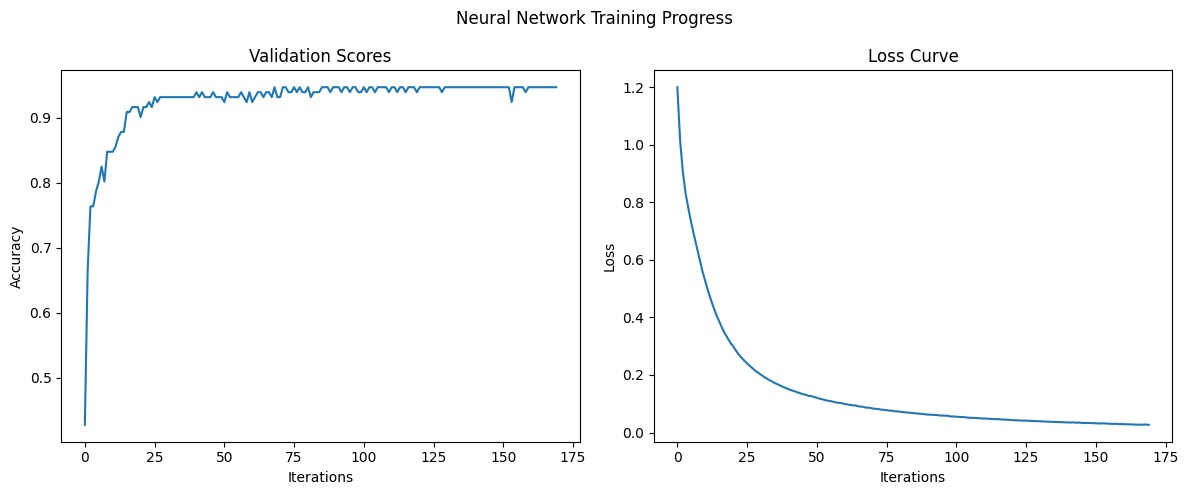

Bagging MLP


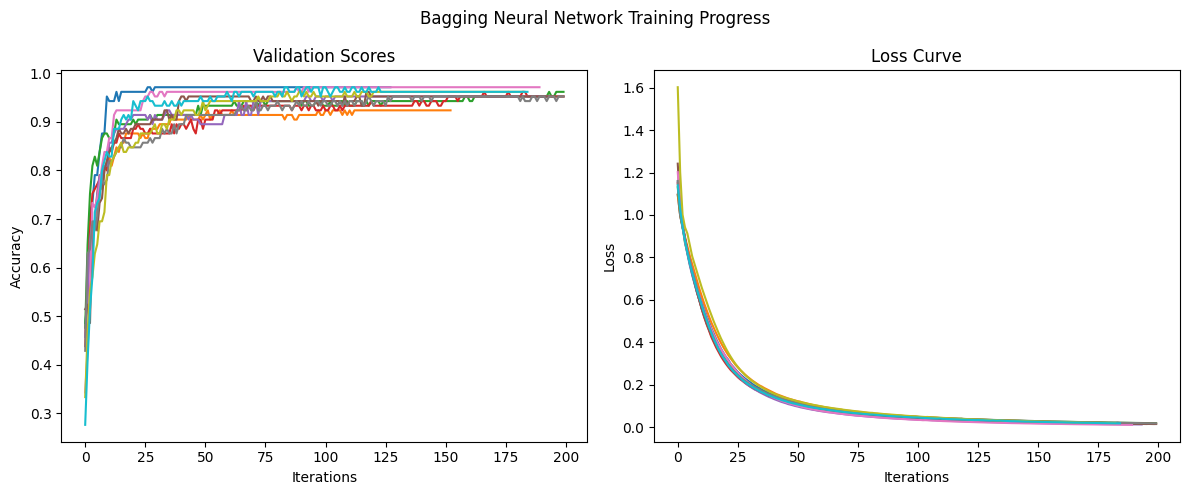

Normal MLP


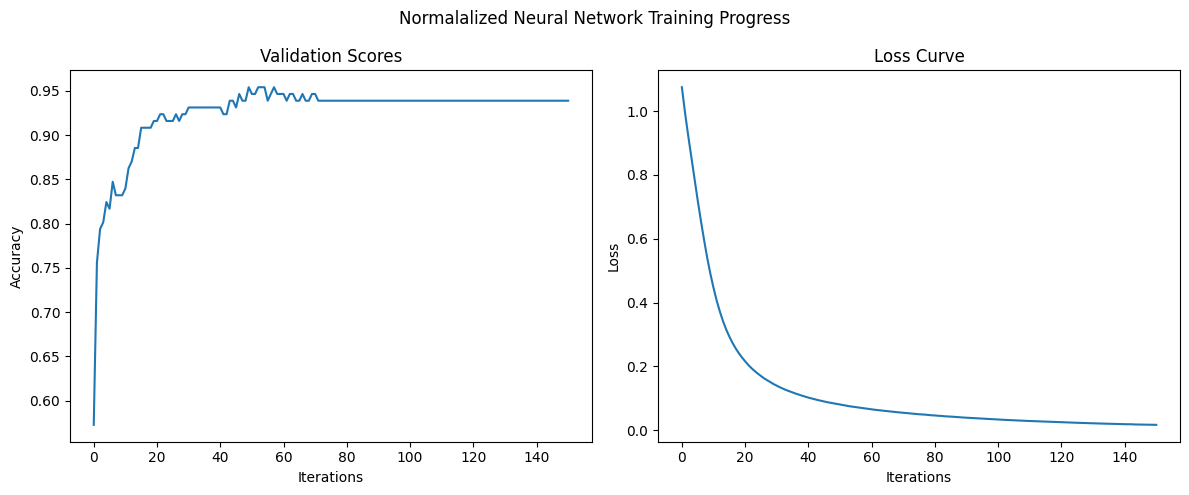

Normal Bagging MLP


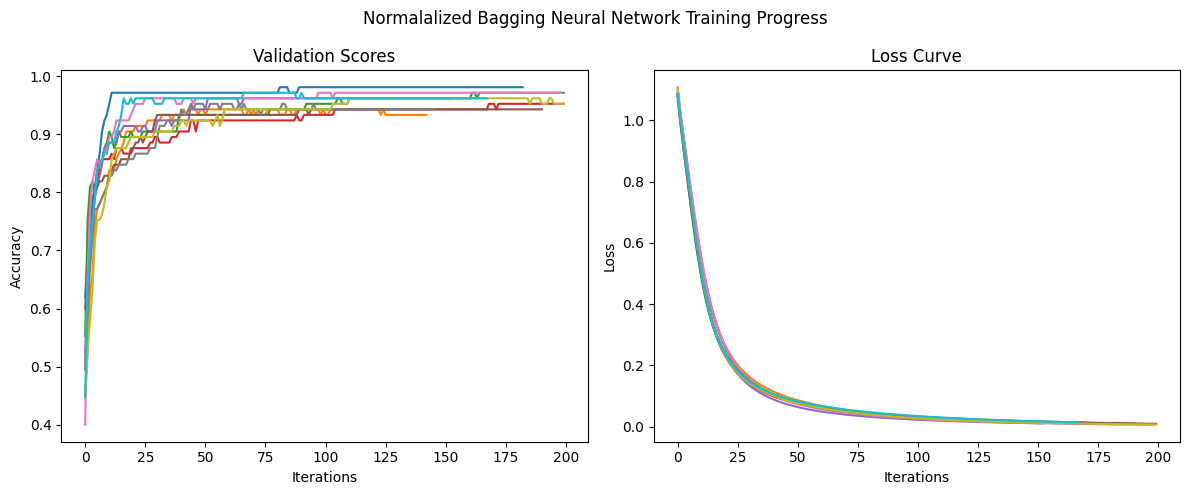

In [48]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


print("Base MLP")
# Plot validation scores on the first subplot
if hasattr(mlp, 'validation_scores_'):
    ax[0].plot(mlp.validation_scores_)
    ax[0].set_title('Validation Scores')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Accuracy')

# Plot loss curve on the second subplot
ax[1].plot(mlp.loss_curve_)
ax[1].set_title('Loss Curve')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Loss')

# Add overall title and adjust layout
plt.suptitle('Neural Network Training Progress')
plt.tight_layout()

# Display the figure
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

print("Bagging MLP")
all_val = []
all_loss = []

for i, ml in enumerate(bagging.estimators_):
    ax[0].plot(ml.validation_scores_)
    ax[0].set_title('Validation Scores')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(ml.loss_curve_)
    ax[1].set_title('Loss Curve')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')


# Add overall title and adjust layout
plt.suptitle('Bagging Neural Network Training Progress')
plt.tight_layout()

# Display the figure
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

print("Normal MLP")
# Plot validation scores on the first subplot
if hasattr(nmlp, 'validation_scores_'):
    ax[0].plot(nmlp.validation_scores_)
    ax[0].set_title('Validation Scores')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Accuracy')

# Plot loss curve on the second subplot
ax[1].plot(nmlp.loss_curve_)
ax[1].set_title('Loss Curve')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Loss')

# Add overall title and adjust layout
plt.suptitle('Normalalized Neural Network Training Progress')
plt.tight_layout()

# Display the figure
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

print("Normal Bagging MLP")
all_val = []
all_loss = []

for i, ml in enumerate(normBagging.estimators_):
    ax[0].plot(ml.validation_scores_)
    ax[0].set_title('Validation Scores')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(ml.loss_curve_)
    ax[1].set_title('Loss Curve')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')


# Add overall title and adjust layout
plt.suptitle('Normalalized Bagging Neural Network Training Progress')
plt.tight_layout()

# Display the figure
plt.show()

